# Capstone Two - 7.6 Data Wrangling

*this is a final version of the process, I will add notes describing any details from the initial wrangling procedure*

#### Contents
- [Collection](#Collection)
- [Organization](#Organization)
- [Definition](#Definition)
- [Cleaning](#Cleaning)

## Collection
**~1.5k games * 3.5 games processed per s --> ~7 minutes**

- collect list of games `/games?<date selection>`, gameIDs
- iterate through list ~~`/game-stats?<gameID>`~~
  - use `/stat-pages/game/<gameID>` to get team information once per team
  - and everything else
- fill table with each return
  - feature names harmonized from different sources with `stat_keys` dict
  - some cleaning done *in situ*
- *note: 2023 season in progress, data constantly being updated*

In [1]:
# import libraries
import requests
import json
import pandas as pd
from tqdm import tqdm
import numpy as np

#### Collect all Game IDs

In [2]:
# list of games
URL = 'https://www.backend.audlstats.com/api/v1/games?'
parameters = 'date=2011:2023' # all games in league history

URL = f'{URL}{parameters}'
r = requests.get(URL)
if r.status_code == 200:
    games = r.json()['data']
else:
    print(r.status_code)

In [3]:
gamelist = [val['gameID'] for val in games if val['status'] == 'Final']

In [4]:
print(len(gamelist))
print(gamelist[0:3])

1526
['2019-allstars', '2023-05-19-LA-SLC', '2023-05-06-DAL-ATX']


---

#### Prepare for stat collections

In [10]:
# feature renames
stat_keys =  {'completionsNumer': 'completions',
 'completionsDenom': 'throws',
 'hucksNumer': 'hucks_completed',
 'hucksDenom': 'hucks',
 'blocks': 'blocks',
 'turnovers': 'turnovers',
 'oLineScores': 'o_scores',
 'oLinePoints': 'o_points',
 'oLinePossessions': 'o_possessions',
 'dLineScores': 'd_scores',
 'dLinePoints': 'd_points',
 'dLinePossessions': 'd_possessions',
 'redZoneScores': 'rz_scores',
 'redZonePossessions': 'rz_possessions'}

In [29]:
# initialize data frames, run this cell again when testing
start = pd.DataFrame(columns = ['game','date','tz','location','week','home','away','home_score','away_score'])
teams = pd.DataFrame(columns = ['abbrev', 'city', 'name', 'primary', 'secondary'])

---
#### Example Game Stats Return

***Enable Scrolling for Output if running locally. This will look ugly on Github***

In [22]:
for key in r.json().keys(): print(key,'\n', r.json()[key], '\n\n')

game 
 {'id': 2814, 'team_season_id_home': 240, 'team_season_id_away': 248, 'status_id': 100, 'score_home': 24, 'score_away': 17, 'live': None, 'reg_season': True, 'ignore_game': False, 'lock': True, 'start_timestamp': '2022-07-29T19:00:00.000Z', 'start_timezone': 'EDT', 'start_time_tbd': None, 'aw_section': 'week-14', 'score_times_home': [0, 119, 202, 288, 561, 632, 719, 810, 916, 1010, 1050, 1152, 1229, 1300, 1420, 1499, 1579, 1985, 2066, 2259, 2374, 2508, 2650, 2695, 2837], 'score_times_away': [0, 99, 155, 222, 350, 606, 758, 875, 980, 1090, 1331, 1406, 1525, 1906, 2012, 2180, 2220, 2302], 'ext_game_id': '2022-07-29-OTT-DC', 'update_timestamp': '2022-07-31T02:03:02.298Z', 'location_id': 13, 'ls_game_id': '731e0272-cdbd-43ca-9d5e-0615f0f0a68f', 'ticket_url': 'https://shop.thedcbreeze.com/collections/tickets', 'streaming_url': 'https://audltv.vhx.tv/videos/ottawa-at-dc-07-29-2022', 'roster_set': True, 'roster_set_1': True, 'roster_set_2': True, 'team_season_home': {'id': 240, 'team_id

---

#### Loop, Collect

*small testing example first, then big run*

In [12]:
# every 100th game
# use slice of gamelist in following cell
print('testing for', len(gamelist[0:-1:100]), 'games')

testing for 16 games


In [30]:
# LOOP, initialize dataframes above
# testing: with tqdm(gamelist[0:-1:100]) as pbar:
with tqdm(gamelist) as pbar:
    for gameID in pbar:
        pbar.set_postfix(game=gameID)
        
        # complete information
        URL = f'https://www.backend.audlstats.com/stats-pages/game/{gameID}'
        r = requests.get(URL)
        if r.status_code == 200:
            data = r.json().get('game')
        else:
            print(r.status_code, 'for', gameID)
            continue
        if not data:
            print('no data for', gameID)
            continue

        # basic game stats
        gamekey = data['id']
        start.loc[gamekey,'game'] = gameID
        start.loc[gamekey,'date'] = data['start_timestamp']
        start.loc[gamekey,'tz'] = data['start_timezone']
        start.loc[gamekey,'location'] = data['location_id']
        start.loc[gamekey,'week'] = data['aw_section']
        start.loc[gamekey,'home'] = data['team_season_home']['team']['name']
        start.loc[gamekey,'away'] = data['team_season_away']['team']['name']
        start.loc[gamekey,'home_score'] = data['score_home']
        start.loc[gamekey,'away_score'] = data['score_away']

        # collect team information once per team
        for val in ['team_season_home', 'team_season_away']:
            teamkey = data[val]['team']['id']
            if teamkey not in teams.index:
                teams.loc[teamkey, 'abbrev'] = data[val]['abbrev']
                teams.loc[teamkey, 'city'] = data[val]['city']
                teams.loc[teamkey, 'name'] = data[val]['team'].get('name')
                # colors not provided for All-Stars teams
                teams.loc[teamkey, 'primary'] = data[val]['team'].get('primary_hex')
                teams.loc[teamkey, 'secondary'] = data[val]['team'].get('secondary_hex')

        # detailed home and away stats
        for val in ['tsgAway', 'tsgHome']:
            data = r.json().get(val)
            for stat in stat_keys.keys():
                start.loc[gamekey, f'{val[3:].lower()}_{stat_keys[stat]}'] = data[stat]

100%|██████████| 1526/1526 [06:04<00:00,  4.18it/s, game=2022-07-30-IND-ATL]   


**Testing Examples**

In [26]:
teams.head()

,abbrev,city,name,primary,secondary
36,KPS,KPS',All-Stars,None,None
35,Rowan,Rowan's,All-Stars,None,None
6,DET,Detroit,Mechanix,None,None
3,CHI,Chicago,Union,None,None
5,DC,DC,Breeze,None,None


In [28]:
start.head().T

,2492,2672,2813,2715,2858
game,2019-allstars,2021-08-21-CHI-DET,2022-07-08-PHI-DC,2021-08-08-DC-PIT,2022-05-14-MAD-IND
date,2019-06-08T18:00:00.000Z,2021-08-21T18:00:00.000Z,2022-07-08T19:00:00.000Z,2021-08-08T14:00:00.000Z,2022-05-14T19:30:00.000Z
tz,CDT,EDT,EDT,EDT,EDT
location,None,17,13,48,19
week,week-10,week-12,week-11,week-10,week-3
home,All-Stars,Mechanix,Breeze,Thunderbirds,AlleyCats
away,All-Stars,Union,Phoenix,Breeze,Radicals
home_score,28,19,25,16,22
away_score,27,29,24,25,23
away_completions,0.0,214.0,296.0,257.0,284.0


**Final tables after collection**

In [32]:
start.shape

(1526, 37)

In [33]:
teams.shape

(40, 5)

## Organization

- save collected data before any further modifications
- establish scheme for iterations of data modification/cleaning
  - `/data/` for all data
  - `/data/old_data/` for first steps (before this notebook)
    - for whatever reason, team color data were more complete in one of my loops
  - `/data/raw/` for collected data
  - `/data/clean_<X>/` for iterations of cleaned data
  - if final format decided, will leave in data folder

In [139]:
# technically, should ensure folders exist before all these saves . . .
# from pathlib import Path
# Path('some folder').mkdir(exist_ok=True)

In [40]:
collect_date = str(pd.Timestamp.now())[:10]
collect_date

'2023-06-16'

In [41]:
# save to raw data folder as parquet
teams.to_parquet(f'data/raw/team_info_{collect_date}.parquet', engine='pyarrow', compression='gzip')
start.to_parquet(f'data/raw/game_stats_{collect_date}.parquet', engine='pyarrow', compression='gzip')

In [49]:
# restart if needed
start = pd.read_parquet(f'data/raw/game_stats_{collect_date}.parquet')
teams = pd.read_parquet(f'data/raw/team_info_{collect_date}.parquet')

## Definition
- column names adjusted during data collection
- despite dataset memory not large yet, will optimize data types
  - parquet storage useful for maintaing dtypes
- summary statistics will be utilized in cleaning section

#### Game Stats Data Types

In [51]:
start.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1526 entries, 2492 to 2886
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   game                  1526 non-null   object 
 1   date                  1526 non-null   object 
 2   tz                    1526 non-null   object 
 3   location              656 non-null    float64
 4   week                  1526 non-null   object 
 5   home                  1526 non-null   object 
 6   away                  1526 non-null   object 
 7   home_score            1526 non-null   int64  
 8   away_score            1526 non-null   int64  
 9   away_completions      1526 non-null   float64
 10  away_throws           1526 non-null   float64
 11  away_hucks_completed  1526 non-null   float64
 12  away_hucks            1526 non-null   float64
 13  away_blocks           1526 non-null   float64
 14  away_turnovers        1526 non-null   float64
 15  away_o_scores     

In [52]:
start.week.unique()

array(['week-10', 'week-4', 'week-2', 'week-7', 'week-6', 'week-12',
       'week-3', 'week-8', 'week-allstars', 'week-1', 'week-5',
       'championship-weekend', 'week-11', 'playoffs', 'week-15',
       'week-13', 'week-14', 'week-9', 'week-17', 'week-16'], dtype=object)

In [53]:
# change all floats to integers
for col in start.columns[7:]:
    start[col] = start[col].astype(int)
    
# date from object to datetime
start['date'] = pd.to_datetime(start.date)

# simplify week names, could add numer alias for special weeks later
start['week'] = start.week.str.replace('week-','').replace('-weekend','')
start['week'] = start.week.str.replace('-weekend','')

# conversion of some columns to category, could do 2:7
# memory reduction but not as easy to manipulate
for col in start.columns[4:7]:
    start[col] = start[col].astype('category')
    
# logical sorting by date
start = start.sort_values('date')

In [54]:
start.week.unique()

['1', '2', '3', '4', '5', ..., 'championship', 'playoffs', '16', '17', 'allstars']
Length: 20
Categories (20, object): ['1', '10', '11', '12', ..., '9', 'allstars', 'championship', 'playoffs']

In [55]:
start.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1526 entries, 1894 to 3016
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   game                  1526 non-null   object             
 1   date                  1526 non-null   datetime64[ns, UTC]
 2   tz                    1526 non-null   object             
 3   location              656 non-null    float64            
 4   week                  1526 non-null   category           
 5   home                  1526 non-null   category           
 6   away                  1526 non-null   category           
 7   home_score            1526 non-null   int32              
 8   away_score            1526 non-null   int32              
 9   away_completions      1526 non-null   int32              
 10  away_throws           1526 non-null   int32              
 11  away_hucks_completed  1526 non-null   int32              
 12  awa

**decent memory reduction!**

#### Team Info Additions

- manual fixes for all-stars teams end up being a wasted effort, these games will be dropped during cleaning
- still useful for historical team records?
  - 2964: [game stats](https://theaudl.com/stats/game/2022-11-12-allstar-game), [game page](https://theaudl.com/league/game/2022-11-12-allstar-game)
  - 2492: no advanced stats, [game page](https://theaudl.com/league/game/2019-allstars)
- use gamestats table to add historical information to teams
  - games played, wins, losses, ties, years active

In [62]:
# convert back and forth from category
for col in start.columns[5:7]:
    start[col] = start[col].astype(str)

# All-Stars fixes, avoid double-counting for future steps
start.loc[2492,'home'] = "KPS's All-Stars"
start.loc[2492,'away'] = "Rowan's All-Stars"
teams.loc[35,'name'] = "Rowan's All-Stars"
teams.loc[36,'name'] = "KPS's All-Stars"

start.loc[2964,'home'] = "SW All-Stars"
start.loc[2964,'away'] = "EC All-Stars"

teams.loc[98,'abbrev'] = 'SW'
teams.loc[98,'city'] = 'South-West'
teams.loc[98,'name'] = 'SW All-Stars'
teams.loc[99,'abbrev'] = 'EC'
teams.loc[99,'city'] = 'East-Central'
teams.loc[99,'name'] = 'EC All-Stars'

for col in start.columns[5:7]:
    start[col] = start[col].astype('category')

In [91]:
games_played = pd.concat([pd.DataFrame(start.value_counts('home')).T, pd.DataFrame(start.value_counts('away')).T]).fillna(0)
games_played.index = ['home','away']

In [92]:
games_played.iloc[:,0:5]

,AlleyCats,Empire,Radicals,Rush,Mechanix
home,75,75,74,73,72
away,77,73,68,67,70


In [95]:
for team in games_played.columns:
    ind = teams[teams.name == team].index
    teams.loc[ind, 'home'] = games_played[team]['home']
    teams.loc[ind, 'away'] = games_played[team]['away']
    teams.loc[ind, 'games'] = games_played[team].sum()

    teams.loc[ind, 'first'] = start[(start.home == team) | (start.away == team)].date.min().year
    teams.loc[ind, 'last'] = start[(start.home == team) | (start.away == team)].date.max().year
    
    teams.loc[ind, 'wins'] = start[(start.home == team) & (start.home_score > start.away_score) | (start.away == team) & (start.home_score < start.away_score)].shape[0]
    teams.loc[ind, 'losses'] = start[(start.home == team) & (start.home_score < start.away_score) | (start.away == team) & (start.home_score > start.away_score)].shape[0]
    teams.loc[ind, 'ties'] = start[(start.home == team) & (start.home_score == start.away_score) | (start.away == team) & (start.home_score == start.away_score)].shape[0]
    

In [97]:
teams.tail()

,abbrev,city,name,primary,secondary,home,away,games,first,last,wins,losses,ties
8,NSH,Nashville,Nightwatch,None,None,28.0,28.0,56.0,2015.0,2018.0,8.0,48.0,0.0
28,SLC,Salt Lake,Lions,None,None,7.0,7.0,14.0,2014.0,2014.0,0.0,14.0,0.0
25,CHA,Charlotte,Express,None,None,14.0,14.0,28.0,2015.0,2016.0,6.0,22.0,0.0
98,SW,South-West,SW All-Stars,NaN,NaN,1.0,0.0,1.0,2022.0,2022.0,0.0,1.0,0.0
99,EC,East-Central,EC All-Stars,NaN,NaN,0.0,1.0,1.0,2022.0,2022.0,1.0,0.0,0.0


In [98]:
# convert dtypes
teams = teams.convert_dtypes()

In [102]:
# fill in missing colors
first_teams =  pd.read_parquet('data/old_data/team_info.parquet')

for ind in first_teams.index:
    if type(first_teams.loc[ind,'primary']) == str:
        teams.loc[ind,'primary'] = first_teams.loc[ind,'primary']
    if type(first_teams.loc[ind,'secondary']) == str:
        teams.loc[ind,'secondary'] = first_teams.loc[ind,'secondary']

## Cleaning

- save data before additional modifications `/data/clean_0/`
- data after cleaning saved to `/data/clean_1/`
  - removed values in numerical columns set to `-1` instead of `None` to preserve dtype in pandas
  - more data may be cleaned during EDA, some data to be removed was simply marked in this step
- for table HTML formatting, view in local notebook. does not show up on Github
- this step weaves together with EDA, I'll list the most basic cleaning efforts here
  - some 0 values were not actually recorded, ex: D-Points not recorded `=0`, so D-possesions and D-scores are not actually 0.
  - better to drop or fill?
  - if home or away throws `=0`, drop both in case?
- empty text data can be ignored (location, tz, etc . . .) will not be used in model

In [107]:
# save to raw data folder as parquet
teams.to_parquet(f'data/clean_0/team_info_{collect_date}.parquet', engine='pyarrow', compression='gzip')
start.to_parquet(f'data/clean_0/game_stats_{collect_date}.parquet', engine='pyarrow', compression='gzip')

In [108]:
teams.head()

,abbrev,city,name,primary,secondary,home,away,games,first,last,wins,losses,ties
36,KPS,KPS',KPS's All-Stars,<NA>,<NA>,1,0,1,2019,2019,1,0,0
35,Rowan,Rowan's,Rowan's All-Stars,<NA>,<NA>,0,1,1,2019,2019,0,1,0
40,SLC,Salt Lake,Shred,#00477B,#FFAA00,10,11,21,2022,2023,18,3,0
10,LA,LA,Aviators,#A22B2A,#000000,51,54,105,2015,2023,58,47,0
2,ATX,Austin,Sol,#2B3283,#E74A37,44,44,88,2016,2023,40,48,0


In [112]:
start.columns

Index(['game', 'date', 'tz', 'location', 'week', 'home', 'away', 'home_score',
       'away_score', 'away_completions', 'away_throws', 'away_hucks_completed',
       'away_hucks', 'away_blocks', 'away_turnovers', 'away_o_scores',
       'away_o_points', 'away_o_possessions', 'away_d_scores', 'away_d_points',
       'away_d_possessions', 'away_rz_scores', 'away_rz_possessions',
       'home_completions', 'home_throws', 'home_hucks_completed', 'home_hucks',
       'home_blocks', 'home_turnovers', 'home_o_scores', 'home_o_points',
       'home_o_possessions', 'home_d_scores', 'home_d_points',
       'home_d_possessions', 'home_rz_scores', 'home_rz_possessions'],
      dtype='object')

In [113]:
data = start # name change to make code copying easier

#### Evaluate Missing Data

In [114]:
# game data by year, are seasons contained within years?
data.value_counts(data.date.dt.year).sort_index()

date
2012     65
2013    101
2014    126
2015    185
2016    193
2017    179
2018    171
2019    136
2021    134
2022    161
2023     75
dtype: int64

In [123]:
# missing feature data by year

year_table = pd.DataFrame()

for col in data.columns:
    zero_portion = data[data[col]==0].shape[0]/data.shape[0]
    if zero_portion < 0.10:
        continue
    for year in range(data.date.dt.year.min(),data.date.dt.year.max()+1):
        part = data[data.date.dt.year == year]
        if part.shape[0] == 0:
            continue
        year_table.loc[col,year] = round(100*part[part[col]==0].shape[0]/part.shape[0])
        
year_table.style\
    .format(na_rep='',formatter="{:.0f}%")\
    .background_gradient(cmap='bone', axis=None, low=0.5)

,2012,2013,2014,2015,2016,2017,2018,2019,2021,2022,2023
away_hucks_completed,100%,100%,100%,100%,100%,100%,100%,98%,0%,1%,0%
away_hucks,100%,100%,100%,100%,100%,100%,100%,98%,0%,0%,0%
away_o_scores,100%,100%,1%,1%,1%,0%,0%,1%,0%,0%,0%
away_o_points,100%,100%,1%,1%,1%,0%,0%,1%,0%,0%,0%
away_o_possessions,100%,100%,1%,1%,1%,0%,0%,1%,0%,0%,0%
away_d_scores,100%,100%,6%,4%,2%,2%,2%,4%,4%,1%,3%
away_d_points,100%,100%,1%,1%,1%,0%,0%,1%,0%,0%,0%
away_d_possessions,100%,100%,1%,1%,1%,0%,0%,1%,0%,0%,0%
away_rz_scores,100%,100%,100%,100%,100%,100%,100%,98%,0%,0%,0%
away_rz_possessions,100%,100%,100%,100%,100%,100%,100%,98%,0%,0%,0%


#### Feature Distributions before Cleaning

In [125]:
import seaborn as sns
import matplotlib.pyplot as plt

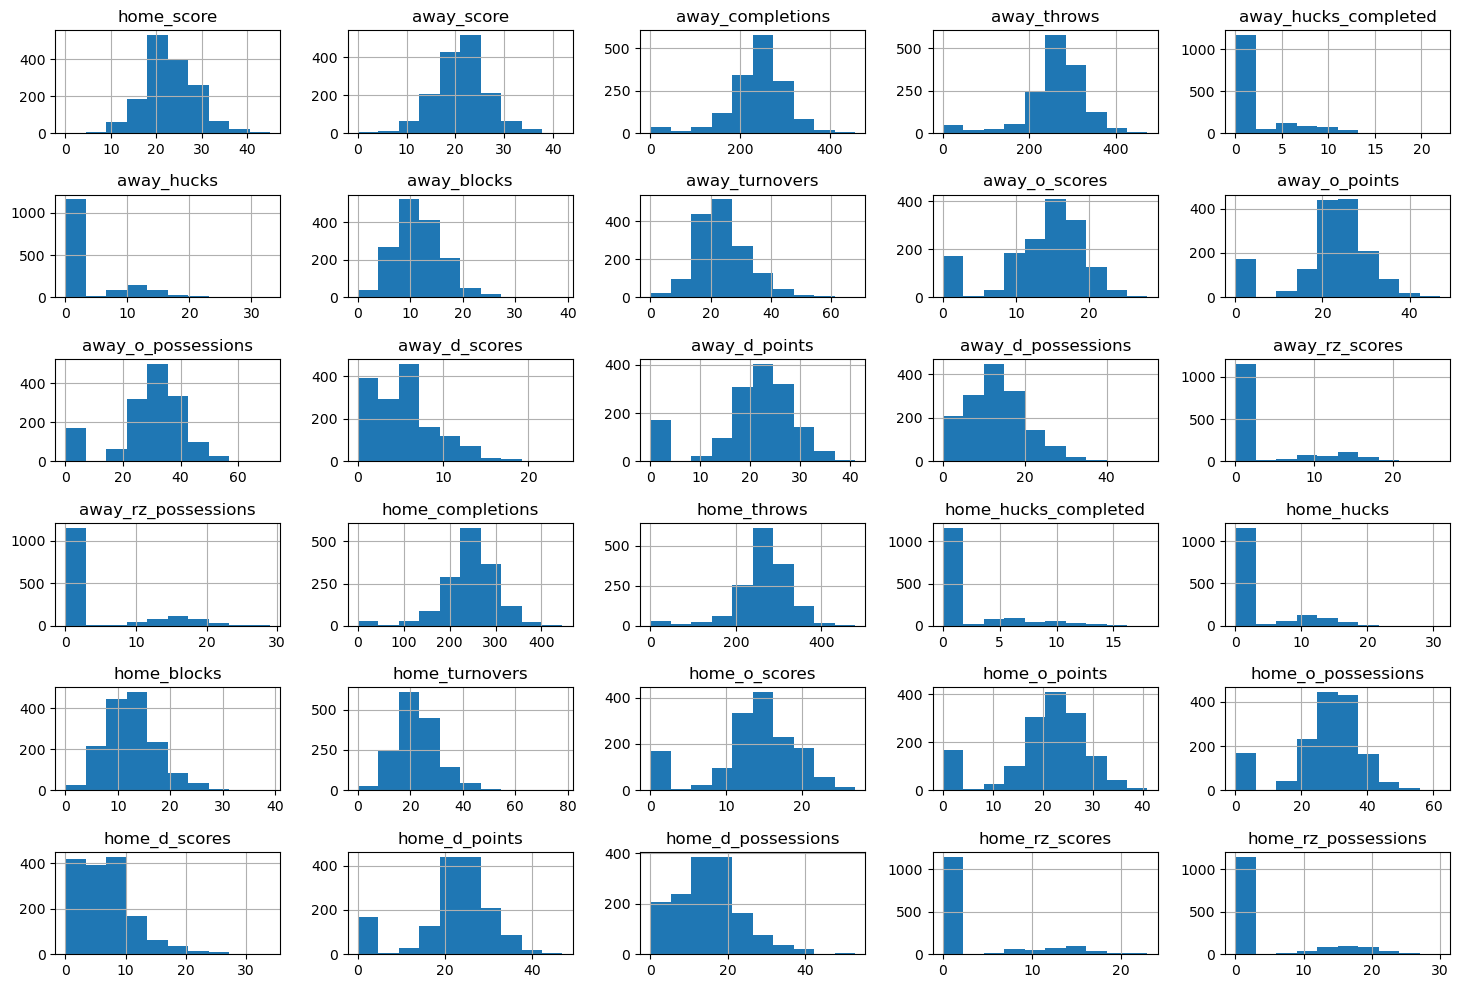

In [127]:
sub = data.loc[:,data.columns[7:]]

sub[sub>=0].hist(figsize=(18,12))
plt.subplots_adjust(hspace=0.6)

plt.savefig('graphs/data_cleaning/initial_distributions.png', dpi=300)
plt.show()

Features to check recording start have high count of `0`

Possible to attempt 0 hucks, but not possible to have 0 points on either O or D. 
Redzone stats may be suspect, too.

Couple of games without any stats recorded will be removed

In [128]:
data[data[data.columns[9:]].sum(axis=1)==0]

,game,date,tz,location,week,home,away,home_score,away_score,away_completions,...,home_blocks,home_turnovers,home_o_scores,home_o_points,home_o_possessions,home_d_scores,home_d_points,home_d_possessions,home_rz_scores,home_rz_possessions
1944,2012-07-14-DET-CON,2012-07-14 19:00:00+00:00,CDT,NaN,14,Constitution,Mechanix,0,10,0,...,0,0,0,0,0,0,0,0,0,0
2492,2019-allstars,2019-06-08 18:00:00+00:00,CDT,NaN,10,KPS's All-Stars,Rowan's All-Stars,28,27,0,...,0,0,0,0,0,0,0,0,0,0


#### Actual Cleaning

*will use `-1` instead of `None` to preserve dtype, data can be easily removed in following sections*

1. Remove 2 games with no recorded stats, index = `1944`,`2492`
      - *delete rows*
2. Remove all huck and redzone data ~~prior to 2021~~, before `2019-08-10`, index = `2499`
      - *set values to `-1`*
3. Remove all "line" (O/D) stats if "points" == 0 
      - *set values to `-1`*
4. Remove all "throw" (home/away) stats if either throws or completions == 0
      - *set values to `-1`*


In [129]:
# no recorded stats except for score
nostats_ind = data[data[data.columns[9:]].sum(axis=1)==0].index
data.drop(index = nostats_ind, inplace=True)

In [130]:
# Remove Line Stats were not recorded, replace with -1 for now
# check: data[data.home_d_points == 0].loc[:,['home_d_points','home_d_scores','home_d_scores']].sum()
print('Line stats removed from', 
      data[(data.away_d_points == 0)|(data.away_o_points == 0)|(data.home_d_points == 0)|(data.home_o_points == 0)].shape[0], 
      'games')

data.loc[data[data.away_d_points == 0].index, ['away_d_points','away_d_scores','away_d_possessions']] = -1
data.loc[data[data.away_o_points == 0].index, ['away_o_points','away_o_scores','away_o_possessions']] = -1

data.loc[data[data.home_d_points == 0].index, ['home_d_points','home_d_scores','home_d_possessions']] = -1
data.loc[data[data.home_o_points == 0].index, ['home_o_points','home_o_scores','home_o_possessions']] = -1


Line stats removed from 171 games


In [131]:
# Check data again
year_table = pd.DataFrame()

for col in data.columns:
    zero_portion = data[data[col]==0].shape[0]/data.shape[0]
    if zero_portion < 0.10:
        continue
    for year in range(data.date.dt.year.min(),data.date.dt.year.max()+1):
        part = data[data.date.dt.year == year]
        if part.shape[0] == 0:
            continue
        year_table.loc[col,year] = round(100*part[part[col]==0].shape[0]/part.shape[0])
        
year_table.where(year_table != 0, None, inplace = True)

year_table.style\
    .format(na_rep='',formatter="{:.0f}%")\
    .background_gradient(cmap='bone', axis=None, low=0.5)

,2012,2013,2014,2015,2016,2017,2018,2019,2021,2022,2023
away_hucks_completed,100%,100%,100%,100%,100%,100%,100%,98%,,1%,
away_hucks,100%,100%,100%,100%,100%,100%,100%,98%,,,
away_rz_scores,100%,100%,100%,100%,100%,100%,100%,98%,,,
away_rz_possessions,100%,100%,100%,100%,100%,100%,100%,98%,,,
home_hucks_completed,100%,100%,100%,100%,100%,100%,100%,98%,1%,,3%
home_hucks,100%,100%,100%,100%,100%,100%,100%,98%,,,
home_rz_scores,100%,100%,100%,100%,100%,100%,100%,98%,,,
home_rz_possessions,100%,100%,100%,100%,100%,100%,100%,98%,,,


In [132]:
# Remove Huck and Redzone data prior to 2020
# Index 2499 was first game with recorded endzone and huck stats
late_stats = [
    'away_hucks_completed','away_hucks','home_hucks_completed','home_hucks',
    'away_rz_scores','away_rz_possessions','home_rz_scores','home_rz_possessions'
            ]
data.loc[data[data.date< pd.to_datetime(data.loc[2499,'date'])].index, late_stats] = -1

In [133]:
# Remove all throwing data, if incomplete, set to -1
drop_throws = ['home_throws','home_completions','away_throws', 'away_completions']

data.loc[\
         data[(data.home_throws==0) | (data.away_throws==0) | (data.home_completions==0) | (data.away_completions==0)\
             ].index, drop_throws] = -1

#### Feature Distributions *after* Cleaning
- much more normal!

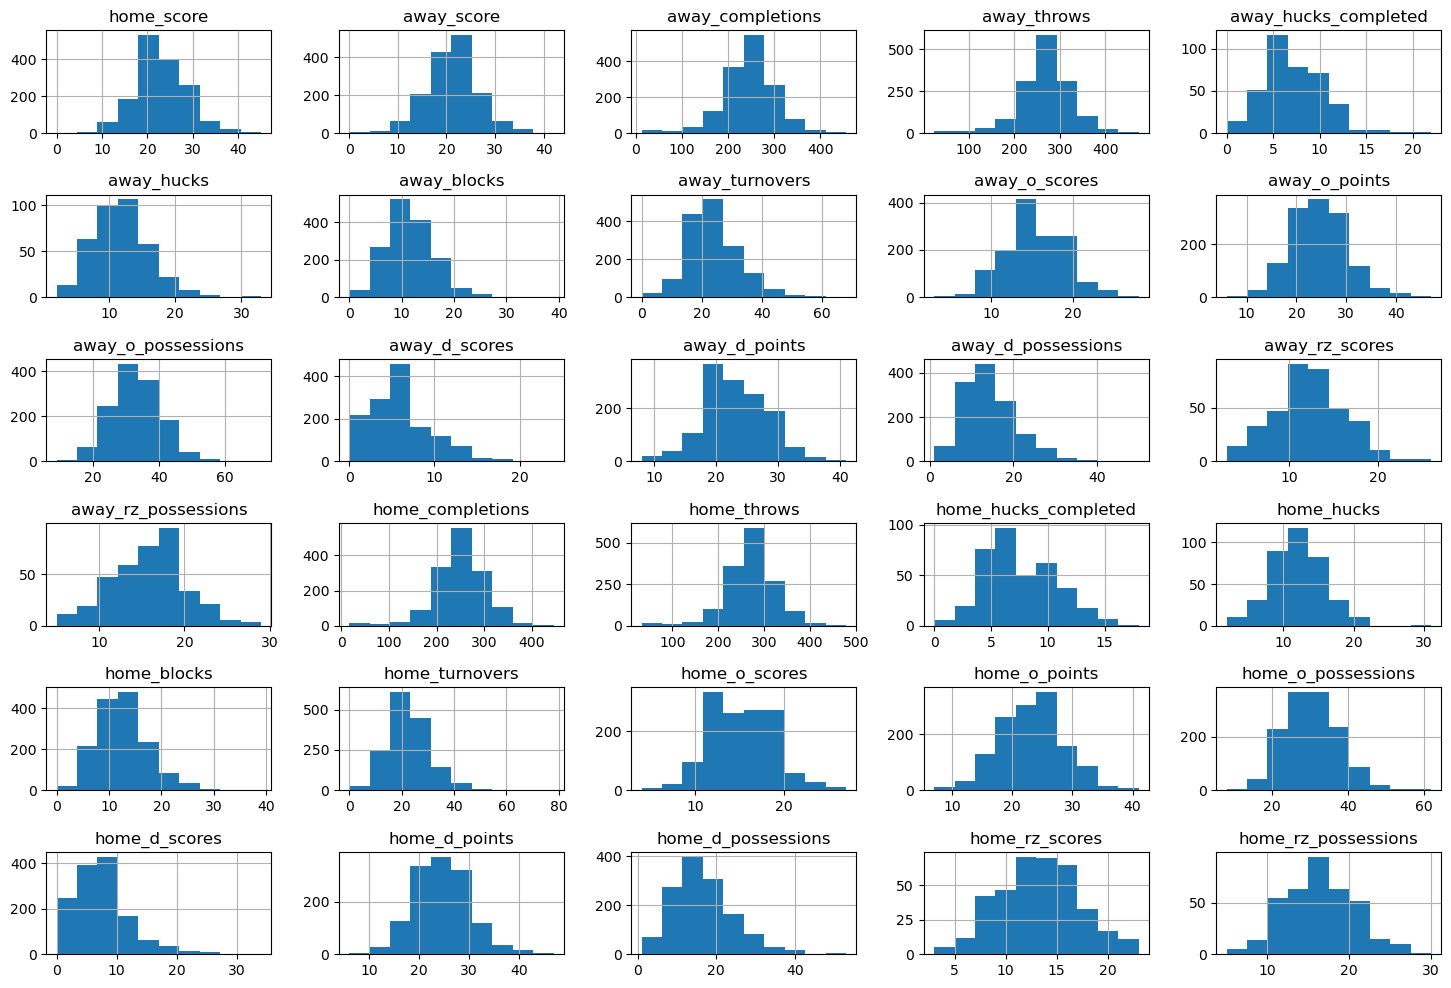

In [134]:
sub = data.loc[:,data.columns[7:]]

sub[sub>=0].hist(figsize=(18,12))
plt.subplots_adjust(hspace=0.6)

plt.savefig('graphs/data_cleaning/clean_1_distributions.png', dpi=300)
plt.show()

#### Save Initial Clean

In [136]:
# save to raw data folder as parquet
teams.to_parquet(f'data/clean_1/team_info_{collect_date}.parquet', engine='pyarrow', compression='gzip')
data.to_parquet(f'data/clean_1/game_stats_{collect_date}.parquet', engine='pyarrow', compression='gzip')

### Previous Cleaning Notes
- **Points,Scores,Possessions**
  - see older graphs
- **Throws**
  - no clear trends with missing data, *58 games with either 0 home or away throws*
  - more recent games *(2 per year from 2014-2016)* seem to be reliable and just missing one team
  - many games prior to 2014 *(52)*, some data seems more bogus

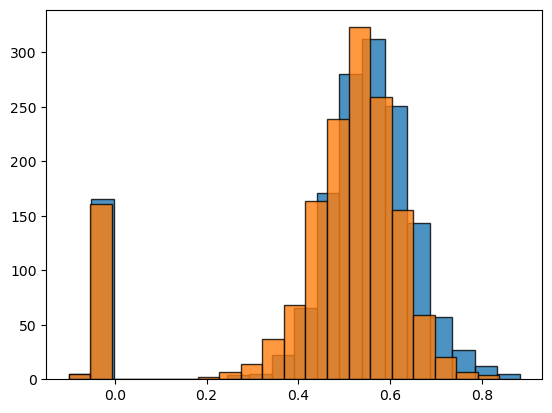

In [137]:
plt.hist(data.away_o_points / (data.home_score + data.away_score), bins=20, ec='k', alpha=0.8)
plt.hist(data.home_o_points / (data.home_score + data.away_score), bins=20, ec='k', alpha=0.8)
plt.show()